# ***Cancer Detection***
## ***Applied Machine Learning W207 Final Project, Fall 2022***
### ***Members***
#### ***1. Chenyu Wang***
#### ***2. Hector Rincon***
#### ***3. Ifrah Javed***
#### ***4. Justin To***
#### ***5. Srila Maiti***

# ***A. Setup***

## ***1. Installing the Libraries***

In [ ]:
!pip install fastai
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## ***2. Importing Libraries***

### ***a. Importing General Purpose Libraries***

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
import subprocess
import gc
from itertools import product
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

### ***b. Importing Image Processing and Visualization Libraries***

In [ ]:
from imutils import rotate as rotate
import cv2
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from skimage.color import gray2rgb
import skimage.io as skio
from imgaug import augmenters as img_aug
import imgaug as iaug
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### ***c. Importing Sklearn Functionalities Libraries***

In [ ]:
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

### ***d. Importing Neural Network Functionalities*** 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from keras.layers.convolutional import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.layers.core import Activation
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import *
from keras.applications.resnet import ResNet152
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input
from keras.applications import MobileNetV2
from keras.applications.inception_v3 import *
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

### ***e. Mounting Google Drive***

In [ ]:
# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

Mounted at /content/gdrive


In [ ]:
tf.__version__

'2.9.2'

# ***B. File Processing***

### ***1. Downloading Image Files from Kaggle***

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [05:29<00:00, 25.6MB/s]
100% 6.31G/6.31G [05:29<00:00, 20.6MB/s]


### ***2. Unzipping the Downaloaded Zip Files***

In [ ]:
!unzip -o -qq \*.zip  && rm *.zip

### ***3. Data Validation and Spot Checks***

#### ***a. Train Files Count***

In [ ]:
!ls -ltr /content/train/ |wc -l

220026


#### ***b. Validating record count of train_labels.csv with train file count***

In [ ]:
!wc -l train_labels.csv

220026 train_labels.csv


#### ***c. Test Files Count***

In [ ]:
!ls -ltr /content/test/ |wc -l

57459


#### ***d. Validating record count of sample_submission.csv with test file count***

In [ ]:
!wc -l sample_submission.csv

57459 sample_submission.csv


#### ***e. Explore file structure of train_labels.csv***

In [ ]:
!head train_labels.csv

id,label
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0
acfe80838488fae3c89bd21ade75be5c34e66be7,0
a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
559e55a64c9ba828f700e948f6886f4cea919261,0


#### ***f. Explore file structure of sample_submission.csv***

In [ ]:
!head sample_submission.csv

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
aa0307865281d4484ddf8c637c348292968b93a7,0
f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0


# ***C. Support Functionalities***

### ***1. Defining Parameters***

In [ ]:
CONTRAST_FACTOR = 3
DELTA = 0.3

train_path = 'train/'
test_path = 'test/'

current_working_dir = os.getcwd()

train_label_file = 'train_labels.csv'
test_label_file = 'sample_submission.csv'

image_file_extension = '.tif'

train_files_path = os.path.join(current_working_dir, train_path)
test_files_path = os.path.join(current_working_dir, test_path)

# declare constants for reproduciblity
RANDOM_STATE = 20220922

# Finding split positions
split = (0.30, 0.10, 0.10)

process_chunk_size = 200
zoom_range = (0.4, 0.5)

tf.random.set_seed(1234)
np.random.seed(1234)

'''
!rm -rf /content/image_processing
!mkdir /content/image_processing
!mkdir /content/image_processing/train /content/image_processing/test /content/image_processing/validation
!mkdir /content/image_processing/train/positive /content/image_processing/train/negative
!mkdir /content/image_processing/test/positive /content/image_processing/test/negative
!mkdir /content/image_processing/validation/positive /content/image_processing/validation/negative

image_processing_train_positive_path = '/content/image_processing/train/positive'
image_processing_train_negative_path = '/content/image_processing/train/negative'

image_processing_validation_positive_path = '/content/image_processing/validation/positive'
image_processing_validation_negative_path = '/content/image_processing/validation/negative'

image_processing_test_positive_path = '/content/image_processing/test/positive'
image_processing_test_negative_path = '/content/image_processing/test/negative'

image_processing_train_path = "/content/image_processing/train/"
image_processing_validation_path = "/content/image_processing/validation/"
image_processing_test_path = "/content/image_processing/test/"
'''

color_image_augmentation_list = ['adjust_random_brightness',
                                 'adjust_random_contrast',
                                 'random_flip_left_right',
                                 'random_flip_up_down',
                                 'rotate_image_by_angle',
                                 'rotate_image_by_90_deg',
                                 'rotate_image_by_180_deg',
                                 'random_zoom',
                                 'resize_with_crop_or_pad'
                                ]
grayscale_image_augmentation_list = ['convert_from_rgb_to_grayscale',
                                     'adjust_random_brightness',
                                     'adjust_random_contrast',
                                     'random_flip_left_right',
                                     'random_flip_up_down',
                                     'rotate_image_by_angle',
                                     'rotate_image_by_90_deg',
                                     'rotate_image_by_180_deg',
                                     'random_zoom',
                                     'resize_with_crop_or_pad'
                                    ]

image_shape = 96
kfold_cv_cnt = 5

sample_size = 75000
batch_size = 192
image_size = 96

### ***2. Image Processing Class***

In [ ]:
class image_processing:
    """
    This class contains methods for image processing.
    """
    def __init__(self):
        None
    
    def read_image_file_in_np_array(self, image_list):
        """
        This function reads each image file in a Numpy array and returns it.
        """
        return np.asarray([skio.imread(image_file, plugin = "tifffile") for image_file in image_list])
    
    def convert_np_array_to_tensor(self, np_image_array):
        """
        This function converts the numpy array representation of each image in tensor.
        """
        return tf.convert_to_tensor(np_image_array, dtype = tf.float32)

    def convert_int_tf_to_float(self, tf_image_list):
        """
        This function converts integer TF value to float.
        """
        return np.asanyarray([tf.cast(img, tf.float32) for img in tf_image_list])
    
    def convert_from_rgb_to_grayscale(self, tf_image_list, large_list_ind = False):
        """
        This function converts color image to grayscale.
        """
        if large_list_ind == False:
            return tf.image.rgb_to_grayscale(tf_image_list) / 255.0
        else:
            None
    
    def combine_train_val(self, x_train, X_val, y_train, y_val):
        """
        This function combines train and validation data, shuffles them and 
        returns back suffled data for k-fold cross validation.
        """
        X_train_kfold = tf.concat([X_train, X_val] , axis = 0)
        y_train_kfold = tf.concat([y_train, y_val] , axis = 0)

        print("Shuffling the kfold train data...")
        tf.random.set_seed(1234) # for reproducibility
    
        test_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_train_kfold)[0], dtype = tf.int32))
        X_train_kfold = tf.gather(X_train_kfold, test_shuffle_indices)
        y_train_kfold = tf.gather(y_train_kfold, test_shuffle_indices).numpy()
        
        print(f"X_train_kfold shape: {X_train_kfold.shape}")
        print(f"y_train_kfold shape: {y_train_kfold.shape}")

    def adjust_brightness(self, tf_image_list, delta):
        """
        This function adjusts the image brightness.
        """
        return tf.image.adjust_brightness(tf_image_list, delta = delta)

    def adjust_random_brightness(self, tf_image_list, max_delta = .3, seed = (1,2)):
        """
        This function adjusts random image brightness.
        """
        return tf.image.stateless_random_brightness(tf_image_list, max_delta = max_delta, seed = seed)

    def adjust_contrast(self, tf_image_list, contrast_factor):
        """
        This function adjusts contrast of the image.
        """
        return tf.image.adjust_contrast(tf_image_list, contrast_factor = contrast_factor)

    def adjust_random_contrast(self, contrast_factor, lower = .2, upper = .5, seed = (1,2)):
        """
        This function randomly contrasts images during training.
        """
        return tf.image.stateless_random_contrast(contrast_factor, lower, upper, seed)

    def flip_left_right(self, tf_image_list):
        """
        This function applies flips the image from left to right.
        """
        return tf.image.flip_left_right(tf_image_list)

    def random_flip_left_right(self, tf_image_list, seed = (1,2)):
        """
        This function randomly flips images left-right during training.
        """
        return tf.image.stateless_random_flip_left_right(tf_image_list, seed)

    def flip_up_down(self, tf_image_list):
        """
        This function flips the image up-down.
        """
        return tf.image.flip_up_down(tf_image_list)
    
    def random_flip_up_down(self, tf_image_list, seed = (1,2)):
        """
        This function flips the image up-down.
        """
        return tf.image.stateless_random_flip_up_down(tf_image_list, seed)

    def rotate_image_by_90_or_180_or_270_deg(self, tf_image_list, k = 1):
        """
        This function rotates images by 90/180/270 degrees.
        k = 1 : 90 degree rotation
        k = 2 : 180 degree rotation
        k = 3 : 270 degree rotation
        """
        return tf.image.rot90(tf_image_list, k)

    def rotate_image_by_angle(self, tf_image_list, angle = tf.constant(np.pi/8)):
        """
        This function rotates images by a given angle.
        """
        rotate_layer = tf.keras.layers.RandomRotation(0.2)
        rotated_image = rotate_layer(tf_image_list) 
        return rotated_image    
    
    def random_zoom(self, tf_image_list):
        """
        This function zooms the image.
        """
        zoom_layer = tf.keras.layers.RandomZoom(.5, .2)
        zoomed_image = zoom_layer(tf_image_list) 
        return zoomed_image

    def random_crop(self, tf_image_list, crop_height = 16, crop_width = 16):
        """
        This function randomly crops the image.
        """
        crop_layer = tf.keras.layers.RandomCrop(crop_height, crop_width)
        cropped_image = crop_layer(tf_image_list) 
        return cropped_image

    def resize_with_crop_or_pad(self, tf_image_list, crop_height = 32, crop_width = 32):
        """
        This function crops and resizes the central part of the image.
        """
        cropped_image = tf.image.resize_with_crop_or_pad(tf_image_list, crop_height, crop_width)
        resized_image = tf.image.resize(cropped_image, [96, 96])
        return resized_image

### ***3. Misclenious Process Class***

In [ ]:
class misc_processing:
    """
    This class contains methods for misclenious processings.
    """
    def __init__(self):
        None
    
    def generate_fully_qualified_file_name_list(self, file_list):
        """
        This function generates a list of fully qualified file names.
        """
        qualified_file_name_list = [os.path.join(current_working_dir, train_path) + 
                                    img + 
                                    '.tif' 
                                    for img in file_list
                                   ]
        return qualified_file_name_list

    def print_image_original(self, image_file_list, label_list):
        """
        This function prints original images.
        """
        nrows, ncols = 1,4 #print first 4 images
        f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        for i, image in enumerate(image_file_list):
            axs[i].imshow(array_to_img(image))
            pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                         fc=(0.0, 0.0, 0.0, 0.0), 
                         ec=(0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
            pf.set_edgecolor('r')
            axs[i].add_patch(pf)
            axs[i].set(title=label_list[i])

    def print_image_in_diff_orientation(self, image_file):
        """
        This function prints images.
        """
        tf.random.set_seed(1234)
        fig = plt.figure(figsize=(14, 12))
        #fig = plt.figure()
        image = skio.imread(image_file, plugin = "tifffile")
        
        # plot original
        ax = fig.add_subplot(1, 5, 1)
        ax.imshow(array_to_img(image))
        pf = Polygon(((32, 32), (64, 32), (64, 64), (32, 64)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Original', size=15);
        
        # resize
        ax = fig.add_subplot(1, 5, 2)
        img_resize = tf.image.resize(image, size=(224, 224))
        ax.imshow(array_to_img(img_resize))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 1: Resize', size=15);
        
        # adjust brightness
        ax = fig.add_subplot(1, 5, 3)
        img_bright = tf.image.adjust_brightness(img_resize, 0.3)
        ax.imshow(array_to_img(img_bright))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 2: Brightness', size=15);
        
        # adjust contrast
        ax = fig.add_subplot(1, 5, 4)
        img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
        ax.imshow(array_to_img(img_contrast))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 3: Contrast', size=15);
        
        # flip left right
        ax = fig.add_subplot(1, 5, 5)
        img_flip = tf.image.flip_left_right(img_contrast)
        ax.imshow(array_to_img(img_flip))
        pf = Polygon(((80, 80), (144, 80), (144, 144), (80, 144)),
                fc = (0.0, 0.0, 0.0, 0.0), 
                ec = (0.0, 0.9, 0.0 ,0.9), lw=4, linestyle='--')
        pf.set_edgecolor('r')
        ax.add_patch(pf)
        ax.set_title('Step 4: Flip left right');

    def split_data(self, split_indices, df):
        """
        This function splits the input dataframe in train, validation and test set.
        """
        X_train = df[: split_indices[0]]
        X_val = df[split_indices[0] : split_indices[1]]
        X_test = df[split_indices[1]:]
        return X_train, X_val, X_test
    
    def get_id_and_label_list(self, file_path, file_extension):
        """
        This function gets the imgae id and corresponding label.
        """
        file_list = []
        for file_name in glob.glob(file_path + '*' + file_extension):
            file_list.append(file_name)
        return file_list

    def create_label(self, shape, label = 1):
        """
        This function creates labels.
        """
        if label == 1:
            return np.ones(shape).flatten()
        elif label == 0:
            return np.zeros(shape).flatten()
    
    def compute_mean_and_std(self, image_file_list, r_mid_pos = 48, c_mid_pos = 48):
        """
        This function computes mean and std at the center of the image.
        """
        center_pixel_value_list = []
        for image_file in image_file_list:
            image = skio.imread(image_file, plugin = "tifffile")
            center_pixel_value_list.append(image[r_mid_pos, c_mid_pos])
        np_array_center_pixel_value = np.array(center_pixel_value_list)
        return np.mean(np_array_center_pixel_value), np.std(np_array_center_pixel_value)

    def copy_file_from_one_to_other(self, file_names, dest_path):
        "This function moves chunks of files in one to other."
        os.system('cp -r ' + file_names + ' ' + dest_path)

    def process_copy_files(self, file_name_list, dest_path):
        """"
        This function processes moving files from one dir to the other. 
        This is the master process to run actual moving in chunks.
        """
        process_chunk_size = 100
        for idx in range(0, len(file_name_list), process_chunk_size):
            if idx % 10000 == 0:
                print("Processing index: ", idx)
            self.copy_file_from_one_to_other(' '.join(file_name_list[idx : idx + process_chunk_size]), dest_path)
    
    def check_file_count_in_a_directory(self, dir_path):
        """
        This function checks the file count in a directory
        """
        cmd_string = 'ls ' + dir_path + " | wc -l"
        file_count = int(subprocess.check_output(cmd_string, shell=True, text=True).strip())
        return file_count

### ***4. Class Instantiation***

In [ ]:
img_proc = image_processing()
misc_proc = misc_processing()

# ***D. Collecting File Information***

### ***1. Get the Image IDs and Corresponding Labels***

There are 220,025 and 57,458 train and test images respectively(tiff 
extension). Each image is 96 X 96 color images (with 3 channels). We are also given train_labels.csv and sample_submission.csv which contain label information for train and test images respectively.

In [ ]:
#get file names for train and test
train_file_list = []
test_file_list = []

train_file_list = misc_proc.get_id_and_label_list(train_files_path, image_file_extension)
test_file_list = misc_proc.get_id_and_label_list(test_files_path, image_file_extension)

train_label = pd.read_csv(train_label_file)
test_label = pd.read_csv(test_label_file)

print(f"Number of train files : {len(train_file_list)}")
print(f"Number of test files : {len(test_file_list)}")

Number of train files : 220025
Number of test files : 57458


### ***2. Checking for Duplicate IDs***

In [ ]:
df_train_id_count = pd.DataFrame(train_label.groupby(['id'])['id'].count())
df_train_id_count.columns = ['id_count']
df_train_id_count.reset_index(inplace = True)
print("Number of train duplicate entries : ", len(df_train_id_count[df_train_id_count.id_count > 1]))

df_test_id_count = pd.DataFrame(test_label.groupby(['id'])['id'].count())
df_test_id_count.columns = ['id_count']
df_test_id_count.reset_index(inplace = True)
print("Number of test duplicate entries : ", len(df_test_id_count[df_test_id_count.id_count > 1]))

Number of train duplicate entries :  0
Number of test duplicate entries :  0


### ***3. Seperating Postive and Negative Images from the Training Data***

In [ ]:
train_positive_image_id_list = list(train_label[train_label.label==1].id)
train_negative_image_id_list = list(train_label[train_label.label==0].id)

train_positive_images_list = misc_proc.generate_fully_qualified_file_name_list(train_positive_image_id_list)
train_negative_images_list = misc_proc.generate_fully_qualified_file_name_list(train_negative_image_id_list)

print(f"Number of positive images in train set: {len(train_positive_images_list)}")
print(f"Number of negative images in train set: {len(train_negative_images_list)}")

Number of positive images in train set: 89117
Number of negative images in train set: 130908


# ***E. Exploratory Data Visualization***

### ***1. Count Distribution of Train Data***

Text(0.5, 1.0, 'Train Data label Count')

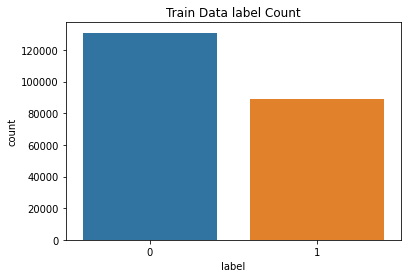

In [ ]:
sns.countplot(data = train_label, x = 'label')
plt.title("Train Data label Count")

### ***2. Train Label Percentage Pie Chart***

In [ ]:
fig = px.pie(train_label, 
             values = train_label['label'].value_counts().values, 
             names = train_label['label'].unique())
fig.update_layout(
    title={
        'text': "Train Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### ***3. Count Distribution of Test Data***

Text(0.5, 1.0, 'Test Data label Count')

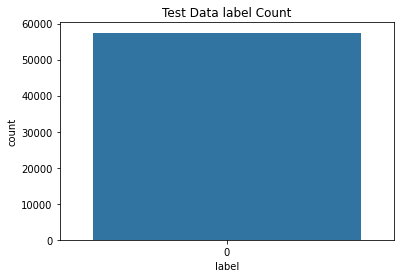

In [ ]:
sns.countplot(data = test_label, x = 'label')
plt.title("Test Data label Count")

### ***4. Train Label Percentage Pie Chart***

In [ ]:
fig = px.pie(test_label, 
             values = test_label['label'].value_counts().values, 
             names = test_label['label'].unique())
fig.update_layout(
    title={
        'text': "Test Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### ***5. Printing Positive Images (Cancer Present) in Different Orientation***

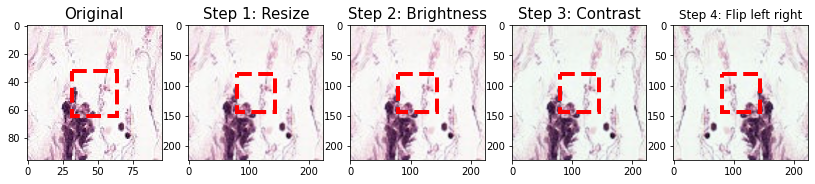

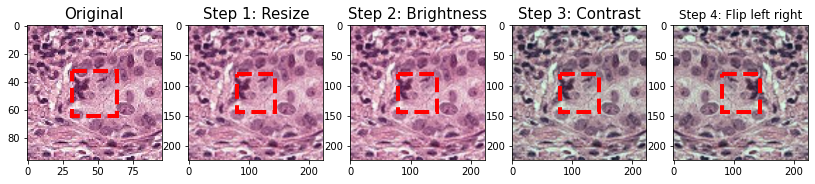

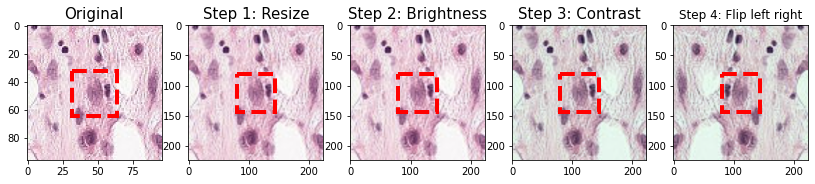

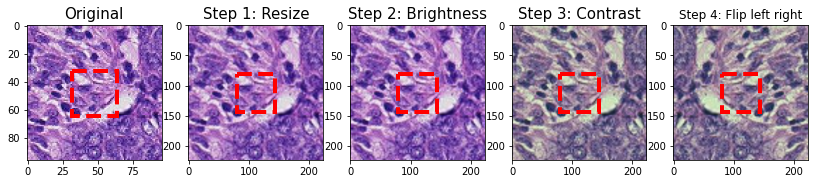

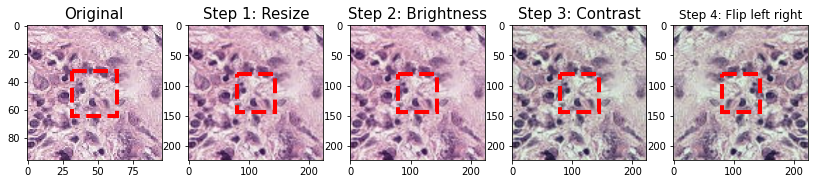

In [ ]:
for image in train_positive_images_list[:5]:
    misc_proc.print_image_in_diff_orientation(image)

### ***6. Printing Negative Images (No Cancer) in Different Orientation***

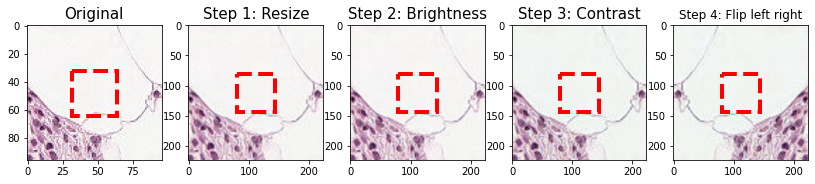

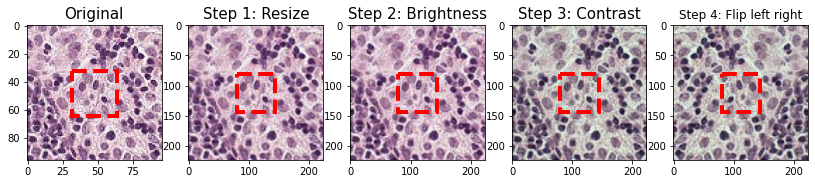

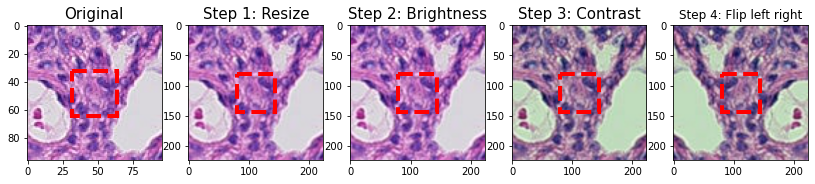

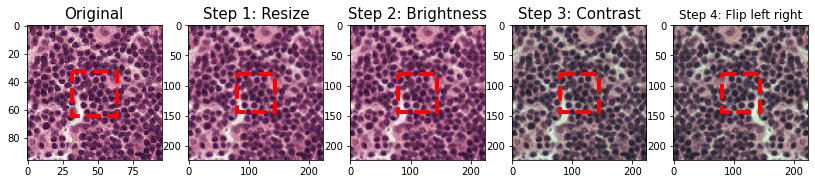

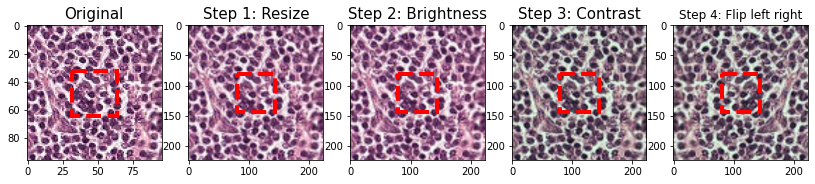

In [ ]:
for image in train_negative_images_list[:5]:
    misc_proc.print_image_in_diff_orientation(image)

In [ ]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/temp/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
training_datagen

# ***F. Considerations*** 
### ***a. We see an imbalance between positive and negative images.***
We will consider equal number of positive and negative images for training and test data. 
### ***b. We do not have correct label for test data.***
We will repurpose part of train data for testing.

# ***G. Data Preprocessing***

### ***1. Seperating Postive and Negative Images***

In [ ]:
train_label_positive = train_label[train_label['label'] == 1]
train_label_negative = train_label[train_label['label'] == 0]

train_label_sample_positive = train_label_positive.head(sample_size)
train_label_sample_negative = train_label_negative.head(sample_size)

# concat the dataframes train_label_sample_positive and train_label_sample_negative
# this will be used for train and validation data
train_label_processed = pd.concat([train_label_sample_negative, train_label_sample_positive], axis = 0).reset_index(drop = True)

remaining_length = len(train_label_positive) - len(train_label_sample_positive)
test_positive_df = train_label_positive[sample_size:]
test_negative_df = train_label_negative[sample_size : sample_size + remaining_length]
df_test = pd.concat([test_positive_df, test_negative_df], axis = 0).reset_index(drop = True)
df_test = shuffle(df_test)

# shuffle
train_label_processed = shuffle(train_label_processed)

In [ ]:
len(train_label_positive), len(train_label_sample_positive), len(train_label_negative), len(train_label_sample_negative)

(89117, 75000, 130908, 75000)

### ***2. Train and Validation Splits***

In [ ]:
# split into training and validation sets
label = train_label_processed['label']
df_train, df_validation = train_test_split(train_label_processed, test_size = 0.2, random_state = 0, stratify = label)

print(f"Length of df_train : {len(df_train)}")
print(f"Length of df_validation : {len(df_validation)}")

sample_positive_label = train_label_sample_positive['label'].values.tolist()
sample_negative_label = train_label_sample_negative['label'].values.tolist()

print(f"Length of df_test : {len(df_test)}")

Length of df_train : 120000
Length of df_validation : 30000
Length of df_test : 28234


In [ ]:
print(df_train['label'].value_counts())
print(df_validation['label'].value_counts())
print(df_test['label'].value_counts())

1    60000
0    60000
Name: label, dtype: int64
1    15000
0    15000
Name: label, dtype: int64
1    14117
0    14117
Name: label, dtype: int64


### ***3. Generating Fully Qualified Image File Name List for Both Positive and Negative Images***

In [ ]:
train_positive_id_list = df_train[df_train.label == 1].id.values.tolist()
train_negative_id_list = df_train[df_train.label == 0].id.values.tolist()

validation_positive_id_list = df_validation[df_validation.label == 1].id.values.tolist()
validation_negative_id_list = df_validation[df_validation.label == 0].id.values.tolist()

test_positive_id_list = df_test[df_test.label == 1].id.values.tolist()
test_negative_id_list = df_test[df_test.label == 0].id.values.tolist()

X_train_img_file_positive = misc_proc.generate_fully_qualified_file_name_list(train_positive_id_list)
X_val_img_file_positive = misc_proc.generate_fully_qualified_file_name_list(validation_positive_id_list)
X_test_img_file_positive = misc_proc.generate_fully_qualified_file_name_list(test_positive_id_list)

X_train_img_file_negative = misc_proc.generate_fully_qualified_file_name_list(train_negative_id_list)
X_val_img_file_negative = misc_proc.generate_fully_qualified_file_name_list(validation_negative_id_list)
X_test_img_file_negative = misc_proc.generate_fully_qualified_file_name_list(test_negative_id_list)

print(f"Length of X_train_img_file_positive : {len(X_train_img_file_positive)}")
print(f"Length of X_train_img_file_negative : {len(X_train_img_file_negative)}")

print(f"Length of X_val_img_file_positive : {len(X_val_img_file_positive)}")
print(f"Length of X_val_img_file_negative : {len(X_val_img_file_negative)}")

print(f"Length of X_test_img_file_positive : {len(X_test_img_file_positive)}")
print(f"Length of X_test_img_file_negative : {len(X_test_img_file_negative)}")

Length of X_train_img_file_positive : 60000
Length of X_train_img_file_negative : 60000
Length of X_val_img_file_positive : 15000
Length of X_val_img_file_negative : 15000
Length of X_test_img_file_positive : 14117
Length of X_test_img_file_negative : 14117


### ***4. Reading Image File in Numpy Array***

In [ ]:
# This process will read each image file and store them in np array
# for both positive and negative images
X_train_positive_np = img_proc.read_image_file_in_np_array(X_train_img_file_positive)
X_val_positive_np = img_proc.read_image_file_in_np_array(X_val_img_file_positive)
X_test_positive_np = img_proc.read_image_file_in_np_array(X_test_img_file_positive)

X_train_negative_np = img_proc.read_image_file_in_np_array(X_train_img_file_negative)
X_val_negative_np = img_proc.read_image_file_in_np_array(X_val_img_file_negative)
X_test_negative_np = img_proc.read_image_file_in_np_array(X_test_img_file_negative)

print(f"Shape of X_train_positive_np : {X_train_positive_np.shape}")
print(f"Shape of X_train_negative_np : {X_train_negative_np.shape}")

print(f"Shape of X_val_positive_np : {X_val_positive_np.shape}")
print(f"Shape of X_val_negative_np : {X_val_negative_np.shape}")

print(f"Shape of X_test_positive_np : {X_test_positive_np.shape}")
print(f"Shape of X_test_negative_np : {X_test_negative_np.shape}")

Shape of X_train_positive_np : (60000, 96, 96, 3)
Shape of X_train_negative_np : (60000, 96, 96, 3)
Shape of X_val_positive_np : (15000, 96, 96, 3)
Shape of X_val_negative_np : (15000, 96, 96, 3)
Shape of X_test_positive_np : (14117, 96, 96, 3)
Shape of X_test_negative_np : (14117, 96, 96, 3)


### ***5. Converting Numpy Array to Tensor***

In [ ]:
# This process converts np array to tensor
# for both positive and negative images
X_train_positive_rgb_tf = img_proc.convert_np_array_to_tensor(X_train_positive_np)
X_val_positive_rgb_tf = img_proc.convert_np_array_to_tensor(X_val_positive_np)
X_test_positive_rgb_tf = img_proc.convert_np_array_to_tensor(X_test_positive_np)

X_train_negative_rgb_tf = img_proc.convert_np_array_to_tensor(X_train_negative_np)
X_val_negative_rgb_tf = img_proc.convert_np_array_to_tensor(X_val_negative_np)
X_test_negative_rgb_tf = img_proc.convert_np_array_to_tensor(X_test_negative_np)

print(f"Shape of X_train_positive_rgb_tf : {X_train_positive_rgb_tf.shape}")
print(f"Shape of X_train_negative_rgb_tf : {X_train_negative_rgb_tf.shape}")

print(f"Shape of X_val_positive_rgb_tf : {X_val_positive_rgb_tf.shape}")
print(f"Shape of X_val_negative_rgb_tf : {X_val_negative_rgb_tf.shape}")

print(f"Shape of X_test_positive_rgb_tf : {X_test_positive_rgb_tf.shape}")
print(f"Shaepe of X_test_negative_rgb_tf : {X_test_negative_rgb_tf.shape}")

Shape of X_train_positive_rgb_tf : (60000, 96, 96, 3)
Shape of X_train_negative_rgb_tf : (60000, 96, 96, 3)
Shape of X_val_positive_rgb_tf : (15000, 96, 96, 3)
Shape of X_val_negative_rgb_tf : (15000, 96, 96, 3)
Shape of X_test_positive_rgb_tf : (14117, 96, 96, 3)
Shaepe of X_test_negative_rgb_tf : (14117, 96, 96, 3)


### ***6. Creating Labels***

#### ***a. Creating Positive Labels***

In [ ]:
Y_train_positive = misc_proc.create_label(len(X_train_positive_rgb_tf))
Y_val_positive = misc_proc.create_label(len(X_val_positive_rgb_tf))
Y_test_positive = misc_proc.create_label(len(X_test_positive_rgb_tf))

#### ***b. Creating Negative Labels***

In [ ]:
Y_train_negative = misc_proc.create_label(len(X_train_negative_rgb_tf), 0)
Y_val_negative = misc_proc.create_label(len(X_val_negative_rgb_tf), 0)
Y_test_negative = misc_proc.create_label(len(X_test_negative_rgb_tf), 0)

### ***7. Mean and STD for Positive and Negative Train Images***

In [ ]:
print("Mean and standard deviation at center for positive train images: ", misc_proc.compute_mean_and_std(X_train_img_file_positive))
print("Mean and standard deviation at center for negative train images: ", misc_proc.compute_mean_and_std(X_train_img_file_negative))

Mean and standard deviation at center for positive train images:  (160.09238333333334, 58.254840083013704)
Mean and standard deviation at center for negative train images:  (168.98001666666667, 69.37960263490632)


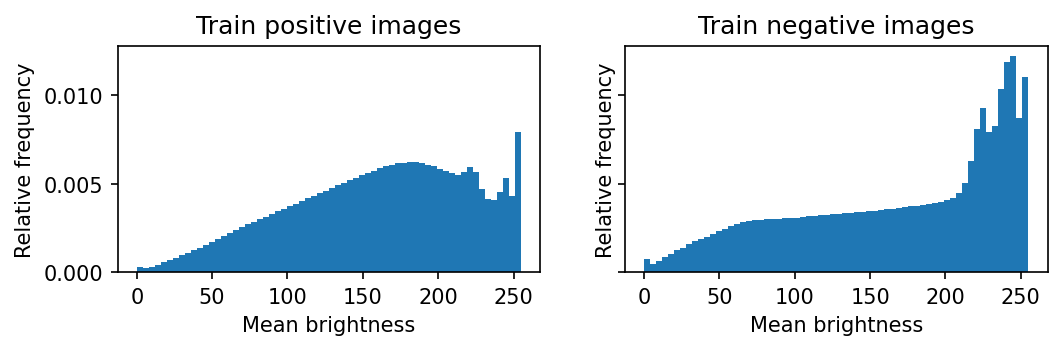

In [ ]:
number_of_bins = 64 
fig,ax = plt.subplots(1,2, sharey = True, sharex = True, figsize = (8,2), dpi = 150)
ax[0].hist(img_proc.read_image_file_in_np_array(X_train_img_file_positive)[:,:,:,(0,1,2)].flatten(),
           bins = number_of_bins, 
           density = True);
ax[1].hist(img_proc.read_image_file_in_np_array(X_train_img_file_negative)[:,:,:,(0,1,2)].flatten(),
           bins = number_of_bins, 
           density = True);

ax[0].set_title("Train positive images");
ax[1].set_title("Train negative images");

ax[0].set_xlabel("Mean brightness")
ax[1].set_xlabel("Mean brightness")
ax[0].set_ylabel("Relative frequency")
ax[1].set_ylabel("Relative frequency");

### ***8. Mean and STD for Positive and Negative Train Images Across RGB Channels***

In [ ]:
print("Average across red, green and blue channels for Train positive images")
print(np.mean(img_proc.read_image_file_in_np_array(X_train_img_file_positive), axis = (0,1,2)))
print("Standard Deviation across red, green and blue channels for Train positive images")
print(np.std(img_proc.read_image_file_in_np_array(X_train_img_file_positive), axis = (0,1,2)))

print("Average across red, green and blue channels for Train X_train_img_file_negative images")
print(np.mean(img_proc.read_image_file_in_np_array(X_train_img_file_negative), axis = (0,1,2)))
print("Standard Deviation across red, green and blue channels for Train X_train_img_file_negative images")
print(np.std(img_proc.read_image_file_in_np_array(X_train_img_file_negative), axis = (0,1,2)))

Average across red, green and blue channels for Train positive images
[176.69625513 128.95957073 175.61657711]
Standard Deviation across red, green and blue channels for Train positive images
[53.87424879 61.84209094 47.41183561]
Average across red, green and blue channels for Train X_train_img_file_negative images
[180.87665293 146.45091832 179.07177636]
Standard Deviation across red, green and blue channels for Train X_train_img_file_negative images
[65.20102044 77.28731372 59.80212398]


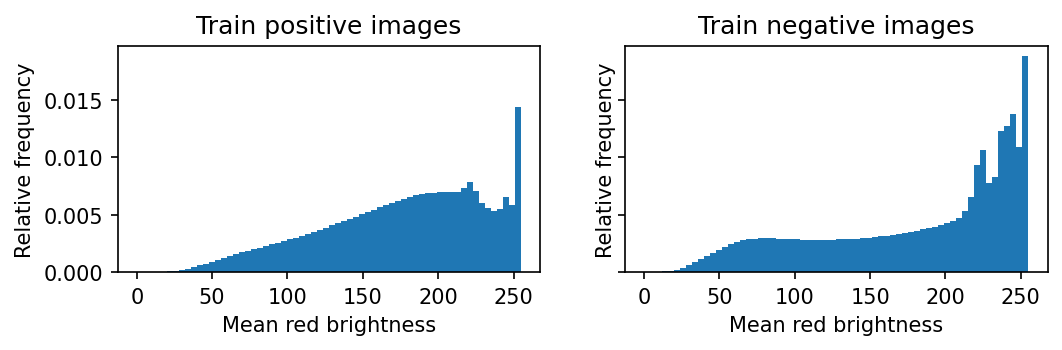

In [ ]:
number_of_bins = 64 
fig,ax = plt.subplots(1,2, sharey = True, sharex = True, figsize = (8,2), dpi = 150)
ax[0].hist(img_proc.read_image_file_in_np_array(X_train_img_file_positive)[:,:,:,(0)].flatten(),
           bins = number_of_bins, 
           density = True);
ax[1].hist(img_proc.read_image_file_in_np_array(X_train_img_file_negative)[:,:,:,(0)].flatten(),
           bins = number_of_bins, 
           density = True);

ax[0].set_title("Train positive images");
ax[1].set_title("Train negative images");

ax[0].set_xlabel("Mean red brightness")
ax[1].set_xlabel("Mean red brightness")
ax[0].set_ylabel("Relative frequency")
ax[1].set_ylabel("Relative frequency");

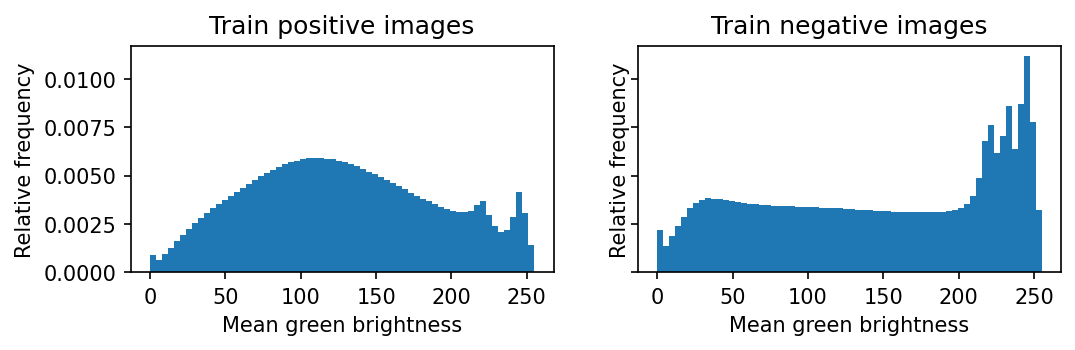

In [ ]:
number_of_bins = 64 
fig,ax = plt.subplots(1,2, sharey = True, sharex = True, figsize = (8,2), dpi = 150)
ax[0].hist(img_proc.read_image_file_in_np_array(X_train_img_file_positive)[:,:,:,(1)].flatten(),
           bins = number_of_bins, 
           density = True);
ax[1].hist(img_proc.read_image_file_in_np_array(X_train_img_file_negative)[:,:,:,(1)].flatten(),
           bins = number_of_bins, 
           density = True);

ax[0].set_title("Train positive images");
ax[1].set_title("Train negative images");

ax[0].set_xlabel("Mean green brightness")
ax[1].set_xlabel("Mean green brightness")
ax[0].set_ylabel("Relative frequency")
ax[1].set_ylabel("Relative frequency");

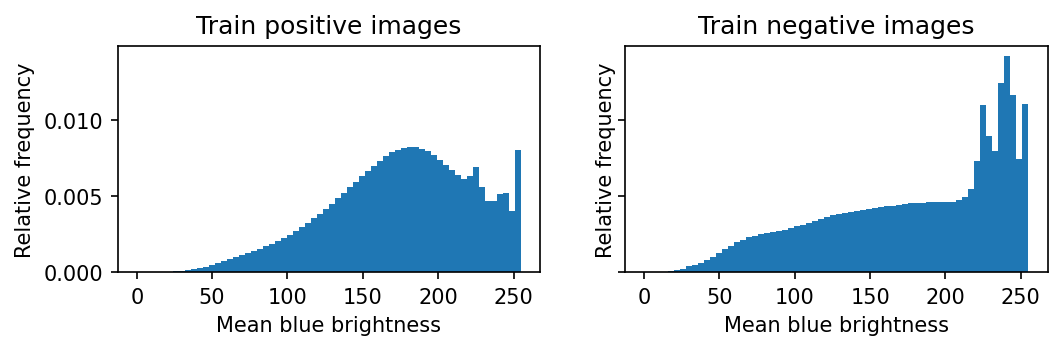

In [ ]:
number_of_bins = 64 
fig,ax = plt.subplots(1,2, sharey = True, sharex = True, figsize = (8,2), dpi = 150)
ax[0].hist(img_proc.read_image_file_in_np_array(X_train_img_file_positive)[:,:,:,(2)].flatten(),
           bins = number_of_bins, 
           density = True);
ax[1].hist(img_proc.read_image_file_in_np_array(X_train_img_file_negative)[:,:,:,(2)].flatten(),
           bins = number_of_bins, 
           density = True);

ax[0].set_title("Train positive images");
ax[1].set_title("Train negative images");

ax[0].set_xlabel("Mean blue brightness")
ax[1].set_xlabel("Mean blue brightness")
ax[0].set_ylabel("Relative frequency")
ax[1].set_ylabel("Relative frequency");

### ***9. Conclusions***

We see larger pixel values in the train negative images compared to train positive images.

# ***H. Image Processing***

In [ ]:
for img_aug_func in grayscale_image_augmentation_list:
    
    print("Image augmentation function : ", img_aug_func)

    if img_aug_func == 'convert_from_rgb_to_grayscale':
        
        print("Handling grayscale conversion for X_train_positive_rgb_tf")
        X_train_positive_tf = img_proc.convert_from_rgb_to_grayscale(X_train_positive_rgb_tf, True)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling grayscale conversion for X_val_positive_rgb_tf")
        X_val_positive_tf = img_proc.convert_from_rgb_to_grayscale(X_val_positive_rgb_tf, True)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling grayscale conversion for X_test_positive_rgb_tf")
        X_test_positive_tf = img_proc.convert_from_rgb_to_grayscale(X_test_positive_rgb_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling grayscale conversion for X_train_negative_rgb_tf")
        X_train_negative_tf = img_proc.convert_from_rgb_to_grayscale(X_train_negative_rgb_tf, True)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling grayscale conversion for X_val_negative_rgb_tf")
        X_val_negative_tf = img_proc.convert_from_rgb_to_grayscale(X_val_negative_rgb_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling grayscale conversion for X_test_negative_rgb_tf")
        X_test_negative_tf = img_proc.convert_from_rgb_to_grayscale(X_test_negative_rgb_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_tf : {X_train_positive_tf.shape}")
        print(f"Shape of X_train_negative_tf : {X_train_negative_tf.shape}")

        print(f"Shape of X_val_positive_tf : {X_val_positive_tf.shape}")
        print(f"Shape of X_val_negative_tf : {X_val_negative_tf.shape}")

        print(f"Shape of X_test_positive_tf : {X_test_positive_tf.shape}")
        print(f"Shape of X_test_negative_tf : {X_test_negative_tf.shape}")

    elif img_aug_func == 'adjust_random_brightness':
      
        print("Handling random brightness adjustment for X_train_positive_tf")
        X_train_positive_aug_tf = img_proc.adjust_random_brightness(X_train_positive_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling random brightness adjustment for X_train_negative_tf")
        X_train_negative_aug_tf = img_proc.adjust_random_brightness(X_train_negative_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")

    elif img_aug_func == 'adjust_random_contrast':
      
        print("Handling contrast adjustment for X_train_positive_aug_tf")
        X_train_positive_aug_tf = img_proc.adjust_random_contrast(X_train_positive_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling contrast adjustment for X_train_negative_aug_tf")
        X_train_negative_aug_tf = img_proc.adjust_random_contrast(X_train_negative_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")

    elif img_aug_func == 'random_flip_left_right':
        
        print("Handling random flip left and right for X_train_positive_aug_tf")
        X_train_positive_aug_tf = img_proc.random_flip_left_right(X_train_positive_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling random flip left and right or X_train_negative_aug_tf")
        X_train_negative_aug_tf = img_proc.random_flip_left_right(X_train_negative_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")

    elif img_aug_func == 'random_flip_up_down':

        print("Handling random flip up and down for X_train_positive_aug_tf")
        X_train_positive_aug_tf = img_proc.random_flip_up_down(X_train_positive_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling random flip up and down or X_train_negative_aug_tf")
        X_train_negative_aug_tf = img_proc.random_flip_up_down(X_train_negative_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")

    elif img_aug_func == 'rotate_image_by_angle':
    
        print("Handling image rotation by an angle for X_train_positive_aug_tf")
        X_train_positive_aug_tf = img_proc.rotate_image_by_angle(X_train_positive_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling image rotation by an angle for X_train_negative_aug_tf")
        X_train_negative_aug_tf = img_proc.rotate_image_by_angle(X_train_negative_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")

    elif img_aug_func == 'rotate_image_by_90_deg':
    
        print("Handling image rotation by 90 deg angle for X_train_positive_aug_tf")
        X_train_positive_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_positive_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling image rotation by 90 deg angle for X_train_negative_aug_tf")
        X_train_negative_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_negative_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")

    elif img_aug_func == 'rotate_image_by_180_deg':
    
        print("Handling image rotation by 180 deg angle for X_train_positive_aug_tf")
        X_train_positive_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_positive_aug_tf, k = 2)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling image rotation by 180 deg angle for X_train_negative_aug_tf")
        X_train_negative_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_negative_aug_tf, k = 2)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")

    elif img_aug_func == 'random_zoom':
    
        print("Handling random zoom for X_train_positive_aug_tf")
        X_train_positive_aug_tf = img_proc.random_zoom(X_train_positive_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling random zoom for X_train_negative_aug_tf")
        X_train_negative_aug_tf = img_proc.random_zoom(X_train_negative_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")
    
    elif img_aug_func == 'resize_with_crop_or_pad':
    
        print("Handling resize with crop or pad for X_train_positive_aug_tf")
        X_train_positive_aug_tf = img_proc.resize_with_crop_or_pad(X_train_positive_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print("Handling resize with crop or pad for X_train_negative_aug_tf")
        X_train_negative_aug_tf = img_proc.resize_with_crop_or_pad(X_train_negative_aug_tf)
        gc.collect()
        tf.keras.backend.clear_session()

        print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
        print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")

Image augmentation function :  convert_from_rgb_to_grayscale
Handling grayscale conversion for X_train_positive_rgb_tf


### ***1. Converting Color Images to Grayscale***

In [ ]:
'''
print("Handling grayscale conversion for X_train_positive_rgb_tf")
X_train_positive_tf = img_proc.convert_from_rgb_to_grayscale(X_train_positive_rgb_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_val_positive_rgb_tf")
X_val_positive_tf = img_proc.convert_from_rgb_to_grayscale(X_val_positive_rgb_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_test_positive_rgb_tf")
X_test_positive_tf = img_proc.convert_from_rgb_to_grayscale(X_test_positive_rgb_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_train_negative_rgb_tf")
X_train_negative_tf = img_proc.convert_from_rgb_to_grayscale(X_train_negative_rgb_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_val_negative_rgb_tf")
X_val_negative_tf = img_proc.convert_from_rgb_to_grayscale(X_val_negative_rgb_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_test_negative_rgb_tf")
X_test_negative_tf = img_proc.convert_from_rgb_to_grayscale(X_test_negative_rgb_tf)
gc.collect()
tf.keras.backend.clear_session()

print(f"Shape of X_train_positive_tf : {X_train_positive_tf.shape}")
print(f"Shape of X_train_negative_tf : {X_train_negative_tf.shape}")

print(f"Shape of X_val_positive_tf : {X_val_positive_tf.shape}")
print(f"Shape of X_val_negative_tf : {X_val_negative_tf.shape}")

print(f"Shape of X_test_positive_tf : {X_test_positive_tf.shape}")
print(f"Shape of X_test_negative_tf : {X_test_negative_tf.shape}")
'''

### ***2. Adjusting Brightness of the Images***

In [ ]:
'''
print("Handling brightness adjustment for X_train_positive_tf")
X_train_positive_aug_tf = img_proc.adjust_brightness(X_train_positive_tf, delta = DELTA)
gc.collect()
tf.keras.backend.clear_session()

print("Handling brightness adjustment for X_train_negative_tf")
X_train_negative_aug_tf = img_proc.adjust_brightness(X_train_negative_tf, delta = DELTA)
gc.collect()
tf.keras.backend.clear_session()

print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")
'''

### ***3. Adjusting Contrast of the Images***

In [ ]:
'''
print("Handling contrast adjustment for X_train_positive_aug_tf")
X_train_positive_aug_tf = img_proc.adjust_contrast(X_train_positive_aug_tf, contrast_factor = CONTRAST_FACTOR)
gc.collect()
tf.keras.backend.clear_session()

print("Handling contrast adjustment for X_train_negative_aug_tf")
X_train_negative_aug_tf = img_proc.adjust_contrast(X_train_negative_aug_tf, contrast_factor = CONTRAST_FACTOR)
gc.collect()
tf.keras.backend.clear_session()

print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")
'''

### ***4. Flip Left and Right***

In [ ]:
'''
print("Handling random flip for X_train_positive_aug_tf")
X_train_positive_aug_tf = img_proc.flip_left_right(X_train_positive_aug_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling random flip for X_train_negative_aug_tf")
X_train_negative_aug_tf = img_proc.flip_left_right(X_train_negative_aug_tf)
gc.collect()
tf.keras.backend.clear_session()

print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")
'''

### ***5. Rotate***

#### ***a. Rotate Images by 90 degrees***

In [ ]:
'''
print("Handling image rotation by 90 degrees for X_train_positive_aug_tf")
X_train_positive_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_positive_aug_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling image rotation by 90 degrees for X_train_negative_aug_tf")
X_train_negative_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_negative_aug_tf)
gc.collect()
tf.keras.backend.clear_session()

print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")
'''

#### ***b. Rotate Images by 180 degrees***

In [ ]:
'''
print("Handling image rotation by 180 degrees for X_train_positive_aug_tf")
X_train_positive_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_positive_aug_tf, k = 2)
gc.collect()
tf.keras.backend.clear_session()

print("Handling image rotation by 180 degrees for X_train_negative_aug_tf")
X_train_negative_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_negative_aug_tf, k = 2)
gc.collect()
tf.keras.backend.clear_session()

print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")
'''

#### ***c. Rotate Images by 270 degrees***

In [ ]:
'''
print("Handling image rotation by 270 degrees for X_train_positive_aug_tf")
X_train_positive_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_positive_aug_tf, k = 3)
gc.collect()
tf.keras.backend.clear_session()

print("Handling image rotation by 270 degrees for X_train_negative_aug_tf")
X_train_negative_aug_tf = img_proc.rotate_image_by_90_or_180_or_270_deg(X_train_negative_aug_tf, k = 3)
gc.collect()
tf.keras.backend.clear_session()

print(f"Shape of X_train_positive_aug_tf : {X_train_positive_aug_tf.shape}")
print(f"Shape of X_train_negative_aug_tf : {X_train_negative_aug_tf.shape}")
'''

### ***6. Adding Back the Augmented Images***

In [ ]:
X_train_positive_tf = tf.concat([X_train_positive_tf 
                              , X_train_positive_aug_tf
                                ] 
                              , axis = 0
                              )
X_train_negative_tf = tf.concat([X_train_negative_tf 
                              , X_train_negative_aug_tf
                                ] 
                              , axis = 0
                              )

Y_train_positive_aug = Y_train_positive
Y_train_negative_aug = Y_train_negative
Y_train_positive = tf.concat([Y_train_positive
                            , Y_train_positive_aug
                             ] 
                           , axis = 0
                            )
Y_train_negative = tf.concat([Y_train_negative
                            , Y_train_negative_aug
                             ] 
                            , axis = 0
                            )

print(f"X_train_positive_tf shape: {X_train_positive_tf.shape}")
print(f"Y_train_positive_tf shape: {Y_train_positive.shape}")

print(f"X_train_negative_tf shape: {X_train_negative_tf.shape}")
print(f"Y_train_negative_tf shape: {Y_train_negative.shape}")

print(f"X_val_positive_tf shape: {X_val_positive_tf.shape}")
print(f"Y_val_positive shape: {Y_val_positive.shape}")

print(f"X_val_negative_tf shape: {X_val_negative_tf.shape}")
print(f"Y_val_negative shape: {Y_val_negative.shape}")

print(f"X_test_positive_tf shape: {X_test_positive_tf.shape}")
print(f"Y_test_positive shape: {Y_test_positive.shape}")

print(f"X_test_negative_tf shape: {X_test_negative_tf.shape}")
print(f"Y_test_negative shape: {Y_test_negative.shape}")

### ***7. Blending Positive and Negative Data***

In [ ]:
X_train = tf.concat([X_train_positive_tf , X_train_negative_tf] , axis = 0)
X_val = tf.concat([X_val_positive_tf , X_val_negative_tf] , axis = 0)
X_test = tf.concat([X_test_positive_tf , X_test_negative_tf] , axis = 0)

y_train = tf.concat([Y_train_positive , Y_train_negative] , axis = 0)
y_val = tf.concat([Y_val_positive , Y_val_negative] , axis = 0)
y_test = tf.concat([Y_test_positive , Y_test_negative] , axis = 0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


### ***8.Shuffling the Images***

#### ***a. Shuffling the Train Data***

In [ ]:
print("Shuffling the train data")
train_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype = tf.int32))
X_train = tf.gather(X_train, train_shuffle_indices)
y_train = tf.gather(y_train, train_shuffle_indices).numpy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

#### ***b. Shuffling the Validation Data***

In [ ]:
print("Shuffling the validation data")
val_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_val)[0], dtype = tf.int32))
X_val = tf.gather(X_val, val_shuffle_indices)
y_val = tf.gather(y_val, val_shuffle_indices).numpy()

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

#### ***c. Shuffling the Test Data***

In [ ]:
print("Shuffling the test data")
test_shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_test)[0], dtype = tf.int32))
X_test = tf.gather(X_test, test_shuffle_indices)
y_test = tf.gather(y_test, test_shuffle_indices).numpy()

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

### ***9. PCA***

In [ ]:
'''
train_images = X_train
pca_96_sq = PCA(n_components = image_shape * image_shape)
pca_96_sq.fit(np.reshape(train_images, (-1, image_shape * image_shape)))

plt.grid()
plt.plot(np.cumsum(pca_96_sq.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
'''

# ***I. Post-processing Visualizations***

### ***a. Printing Traing Data***

In [ ]:
misc_proc.print_image_original(X_train[:4], y_train[:4])

### ***b. Printing Validation Data***

In [ ]:
misc_proc.print_image_original(X_val[:4], y_val[:4])

### ***c. Printing Test Data***

In [ ]:
misc_proc.print_image_original(X_test[:4], y_test[:4])